<a href="https://colab.research.google.com/github/Heng1222/Ohsumed_classification/blob/main/Model/task3_MeSH_LoRA_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                                 Param #
PeftModelForFeatureExtraction                                          --
├─LoraModel: 1-1                                                       --
│    └─RobertaModel: 2-1                                               --
│    │    └─RobertaEmbeddings: 3-1                                     (39,000,576)
│    │    └─RobertaEncoder: 3-2                                        86,971,392
│    │    └─RobertaPooler: 3-3                                         (590,592)
Total params: 126,562,560
Trainable params: 1,916,928
Non-trainable params: 124,645,632
test size: (10000, 3)
train size: (90000, 3)
                                  word_i                               word_j  \
135757  Waterhouse-Friderichsen Syndrome                  Histiocytic Sarcoma   
153617                             Ozena                       Sarcoma, Avian   
61220           Neoplasms, Muscle Tissue         Respiratory Tract Infection

Epoch 1 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.71it/s]


Epoch 1: Train Loss=0.010557, Test Loss=0.008351


Epoch 2 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.55it/s]


Epoch 2: Train Loss=0.008319, Test Loss=0.008298
Early Stopping: Validation loss has not improved for 1 epochs.


Epoch 3 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.69it/s]


Epoch 3: Train Loss=0.008208, Test Loss=0.007998


Epoch 4 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.60it/s]


Epoch 4: Train Loss=0.008754, Test Loss=0.008013
Early Stopping: Validation loss has not improved for 1 epochs.


Epoch 5 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.61it/s]


Epoch 5: Train Loss=0.007804, Test Loss=0.007820


Epoch 6 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.77it/s]


Epoch 6: Train Loss=0.007757, Test Loss=0.007926
Early Stopping: Validation loss has not improved for 1 epochs.


Epoch 7 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.72it/s]


Epoch 7: Train Loss=0.007776, Test Loss=0.007793
Early Stopping: Validation loss has not improved for 2 epochs.


Epoch 8 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.71it/s]


Epoch 8: Train Loss=0.007694, Test Loss=0.007636


Epoch 9 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.73it/s]


Epoch 9: Train Loss=0.007635, Test Loss=0.007663
Early Stopping: Validation loss has not improved for 1 epochs.


Epoch 10 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.71it/s]


Epoch 10: Train Loss=0.007625, Test Loss=0.007827
Early Stopping: Validation loss has not improved for 2 epochs.


Epoch 11 Validation: 100%|██████████| 313/313 [00:24<00:00, 12.62it/s]


Epoch 11: Train Loss=0.007575, Test Loss=0.007626
Early Stopping: Validation loss has not improved for 3 epochs.
Early stopping triggered after 11 epochs. Best validation loss: 0.007636


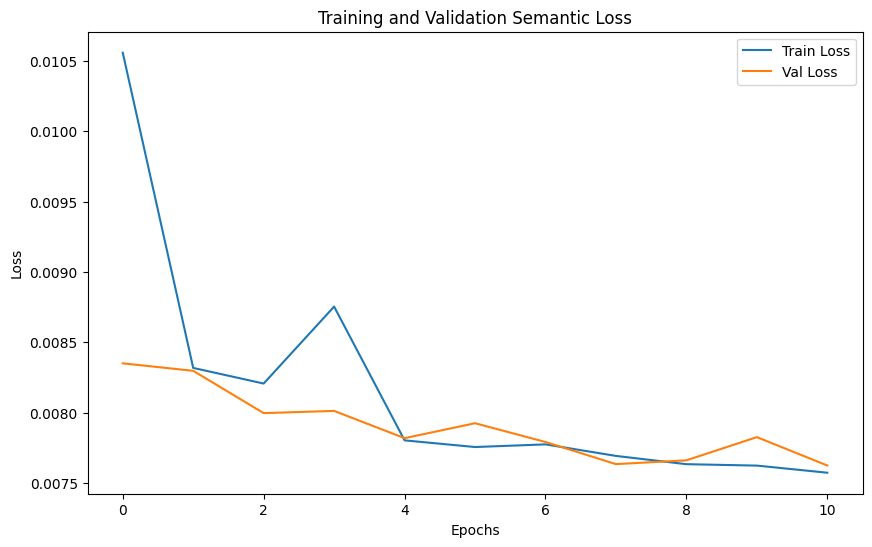

LoRA Adapter saved to 'roberta_semantic_lora'.


In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from torch.optim import AdamW
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm # Import tqdm for progress bar

# 1. 定義論文中的 MeSH Semantic Loss (WSL)
# 公式: L_WSL = (1/|P|) * sum(|CosSim(v_i, v_j) - WUP(s_i, s_j)|)^2
class MeSHSemanticLoss(nn.Module):
    def __init__(self):
        super(MeSHSemanticLoss, self).__init__()

    def forward(self, vec_i, vec_j, target_wup):
        # 計算餘弦相似度 CosSim(v_i, v_j)
        cos_sim = F.cosine_similarity(vec_i, vec_j)
        # 計算誤差 e_WSL = |CosSim - WUP|
        loss = torch.mean((cos_sim - target_wup) ** 2)
        return loss

# 2. 定義資料集類別，用於處理 CSV 讀取的資料
class SemanticPairDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word_i = self.data.iloc[idx]['word_i']
        word_j = self.data.iloc[idx]['word_j']
        wup_sim = self.data.iloc[idx]['wup_similarity']
        return {
            "word_i": word_i,
            "word_j": word_j,
            "wup_sim": torch.tensor(float(wup_sim), dtype=torch.float)
        }

def run_training(csv_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 初始化模型與 Tokenizer
    model_name = "roberta-base"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    base_model = RobertaModel.from_pretrained(model_name)

    # 4. LoRA 配置 (r=16, alpha=32)
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["query", "key", "value", "output.dense"],
        lora_dropout=0.1,
        task_type=TaskType.FEATURE_EXTRACTION
    )

    model = get_peft_model(base_model, lora_config)
    model.to(device)

    # 5. 資料切分 (9:1 訓練集/測試集)
    full_df = pd.read_csv(csv_path)
    full_df = full_df.sample(frac=0.5, random_state=42) # 減少資料量以加速訓練和除錯
    train_df = full_df.sample(frac=0.9, random_state=42) # 90% 訓練集
    test_df = full_df.drop(train_df.index)               # 10% 測試集

    # ==================================
    print(summary(model))
    print(f"test size:", test_df.shape)
    print(f"train size:", train_df.shape)
    print(train_df.head())
    print(test_df.head())
    # ==================================

    train_loader = DataLoader(SemanticPairDataset(train_df), batch_size=32, shuffle=True)
    val_loader = DataLoader(SemanticPairDataset(test_df), batch_size=32)

    optimizer = AdamW(model.parameters(), lr=1e-3)
    criterion = MeSHSemanticLoss()

    # 紀錄 Loss 用於輸出圖表
    train_losses, val_losses = [], []

    # Early Stopping 參數
    patience = 3
    min_delta = 0.0001 # 最小改善幅度
    best_val_loss = float('inf')
    patience_counter = 0

    # 6. 訓練迴圈
    num_epochs = 20 # 增加 epochs 數量以配合 Early Stopping
    for epoch in range(num_epochs):
        model.train() # 確保訓練模式，啟用所有訓練相關行為 (如 Dropout 和 LoRA)
        total_train_loss = 0
        # 使用 tqdm 顯示訓練進度條
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            # 獲取單字向量
            tk_i = tokenizer(batch["word_i"], return_tensors="pt", padding=True, truncation=True).to(device)
            tk_j = tokenizer(batch["word_j"], return_tensors="pt", padding=True, truncation=True).to(device)

            emb_i = model(**tk_i).last_hidden_state[:, 0, :]
            emb_j = model(**tk_j).last_hidden_state[:, 0, :]

            loss = criterion(emb_i, emb_j, batch["wup_sim"].to(device))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # 驗證階段 - 使用 model.eval() 關閉 Dropout 並凍結 BatchNorm，同時使用 torch.no_grad() 關閉梯度計算
        total_val_loss = 0
        with torch.no_grad():
            # 使用 tqdm 顯示驗證進度條
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                tk_i = tokenizer(batch["word_i"], return_tensors="pt", padding=True, truncation=True).to(device)
                tk_j = tokenizer(batch["word_j"], return_tensors="pt", padding=True, truncation=True).to(device)
                emb_i = model(**tk_i).last_hidden_state[:, 0, :]
                emb_j = model(**tk_j).last_hidden_state[:, 0, :]
                total_val_loss += criterion(emb_i, emb_j, batch["wup_sim"].to(device)).item()

        avg_train = total_train_loss / len(train_loader)
        avg_val = total_val_loss / len(val_loader)
        train_losses.append(avg_train)
        val_losses.append(avg_val)

        print(f"Epoch {epoch+1}: Train Loss={avg_train:.6f}, Test Loss={avg_val:.6f}")

        # Early Stopping 檢查
        if avg_val < best_val_loss - min_delta:
            best_val_loss = avg_val
            patience_counter = 0
            # 可以選擇在這裡保存最佳模型
            model.save_pretrained("roberta_semantic_lora_best")
        else:
            patience_counter += 1
            print(f"Early Stopping: Validation loss has not improved for {patience_counter} epochs.")
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.6f}")
                break

    # 7. 繪製 Loss 曲線 [cite: 624]
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Semantic Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 儲存 LoRA 適配器 [cite: 252, 474]
    model.save_pretrained("roberta_semantic_lora")
    print("LoRA Adapter saved to 'roberta_semantic_lora'.")
# 執行
if __name__ == "__main__":
    run_training('mesh_dataset.csv')
